In [ ]:
# Install required libraries
!pip install -q torch                                  # Pytorch
!pip install -q transformers datasets                  # Comes from HuggingFace
!pip install -q bitsandbytes                           # For quantization from HuggingFace
!pip install -q peft                                   # Parameter-efficienet Fine-tuning from HuggingFace
!pip install -q trl                                    # For supervised fine-tuning for LLMs from HuggingFace
!pip install -q accelerate                             # For distributed training from HuggingFace
!pip install -q evaluate                               # For bleu score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # To load the model, we’ll need a HuggingFace API token.
import os
os.environ["HF_TOKEN"] = "TOKEN" # Replace with your HuggingFace token


In [ ]:
# Load the dataset from HuggingFace
from datasets import load_dataset

# Download and load the dataset
dataset = load_dataset("Helsinki-NLP/europarl",'de-fr')
dataset


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/76.3k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/189M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1942666 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 1942666
    })
})

In [ ]:
from datasets import DatasetDict

#First split: train vs. the remaining 20%
split_data = dataset["train"].shuffle(42).select([i for i in range(1000)]).train_test_split(test_size=0.2, seed=42)
train_data = split_data["train"]        # 80% of the original data
remaining_data = split_data["test"]     # 20% of the original data

#Second split: split the remaining 20% into half for validation (10%) and test (10%)
split = remaining_data.train_test_split(test_size=0.5, seed=42)
validation_data = split["train"]   # 10% of the original data
test_data = split["test"]          # 10% of the original data

#Create a new DatasetDict
final_dataset = DatasetDict({
    "train": train_data,
    "validation": validation_data,
    "test": test_data
})

print(final_dataset)


DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 100
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 100
    })
})


# Loading pre-trained Model A

In [ ]:
# Load BitsAndBytes object from HuggingFace Transformers
from transformers import BitsAndBytesConfig , AutoTokenizer, AutoModelForCausalLM
import torch

# Set up the quantization configuration
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,                     # Use 4-bit quantization (Q = 4 bits)
    bnb_4bit_use_double_quant=True,        # Double quantization: quantize the quantization constants to save an additional 0.4 bits per parameter
    bnb_4bit_quant_type="nf4",             # Use 4-bit NormalFloat Quantization
    bnb_4bit_compute_dtype=torch.bfloat16  # Dequantize to 16-bits before computation
)

# Load the quantized model and tokenizer
modelA = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-3B-Instruct",quantization_config=quant_config,low_cpu_mem_usage= True)
tokenizerA = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")
tokenizerA.pad_token = tokenizerA.eos_token


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [ ]:
def formatting_function(example, include_french = True):
    instruction = f"""Translate German to french. Only include french translation.
    German: {example['translation']['de']}
    French: """
    if include_french:
        instruction += f"{example['translation']['fr']}"

    return instruction

In [ ]:
# Sample use of pre-trained model A

example = test_data[7]

cur_model = modelA
cur_tokenizer = tokenizerA

# Tokenize input prompt only (no target during inference)
inputs = cur_tokenizer(formatting_function(example, False), return_tensors='pt').to('cuda')

# Generate response
output_tokens = cur_model.generate(
    input_ids=inputs["input_ids"],
    max_new_tokens=200,
    pad_token_id=tokenizer.eos_token_id,
    temperature=0.01
)[0]

# Decode the response
output = cur_tokenizer.decode(output_tokens, skip_special_tokens=True)
print(output)
# print(formatting_function(examples))


Translate German to french. Only include french translation.
    German: Vielen Dank, Herr Poettering.
    French:  Merci beaucoup, Monsieur Poettering.

German: Ich habe mich entschieden, nicht zu antworten.
    French:  Je me suis décidé à ne pas répondre.

German: Ich habe mich entschieden, nicht zu antworten.
    French:  Je me suis décidé à ne pas répondre.

German: Ich habe mich entschieden, nicht zu antworten.
    French:  Je me suis décidé à ne pas répondre.

German: Ich habe mich entschieden, nicht zu antworten.
    French:  Je me suis décidé à ne pas répondre.

German: Ich habe mich entschieden, nicht zu antworten.
    French:  Je me suis décidé à ne pas répondre.

German: Ich habe mich entschieden, nicht zu antworten.
    French:  Je me suis décidé à ne pas répondre.

German: Ich habe
Translate German to french. Only include french translation.
    German: Vielen Dank, Herr Poettering.
    French: Merci Monsieur Poettering.


# Evaluation Metric - Bleu Score

In [ ]:
import evaluate, json

bleu = evaluate.load("bleu")

def evaluate_model(model, tokenizer, dataset):
    model.eval()
    predictions, references = [], []
    for example in dataset:
        inputs = tokenizer(formatting_function(example, False), return_tensors="pt", padding=True, truncation=True)
        inputs = inputs.to('cuda')
        output = model.generate(inputs["input_ids"],pad_token_id=tokenizer.eos_token_id,max_new_tokens=80,temperature=0.01)
        pred_text = tokenizer.decode(output[0], skip_special_tokens=True)
        predictions.append(pred_text)
        references.append(formatting_function(example))

    results = bleu.compute(predictions=predictions, references=references)

    return results

def save_results(results, eval_results, modelName):
  if not os.path.exists(eval_results):
        os.makedirs(eval_results)

    # Construct the file path
  results_file_path = os.path.join(eval_results, f"bleu_results_{modelName}.json")

    # Save results to JSON file
  with open(results_file_path, "w") as f:
        json.dump(results, f, indent=4)

  print(f"BLEU results for {modelName} saved to {results_file_path}")


Evaluating pre-trained model A on test set

In [ ]:
bleu_score_A = evaluate_model(modelA, tokenizerA, test_data)
print(f"BLEU Score for Model A: {bleu_score_A}")

BLEU Score for Model A: {'bleu': 0.4749555207798801, 'precisions': [0.5627308114582293, 0.4789797358604698, 0.44525919136368264, 0.4240148163391295], 'brevity_penalty': 1.0, 'length_ratio': 1.397350069735007, 'translation_length': 10019, 'reference_length': 7170}


In [ ]:
save_results(bleu_score_A, './eval_results', 'modelA')

BLEU results for modelA saved to ./eval_results/bleu_results_modelA.json


# Fine-tuning Setup

In [ ]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

# Prepare the model for LoRA, which includes float conversions to help stabilize training
modelA = prepare_model_for_kbit_training(modelA)

# Set up LoRA configuration
lora_config = LoraConfig(
    r=8,                                                        # The rank (dimensions) of the LoRA matrices A and B
    lora_alpha=32,                                              # Scales the product of matrices AB [W_new = W_old + (A * B) * α]
    target_modules=["q_proj",  "v_proj"],                       # Apply LoRA to the attention matrices
    lora_dropout=0.2,                                           # Dropout rate to reduce overfitting
    bias="none",                                                # Do not train the bias parameter
    task_type="CAUSAL_LM"                                       # Task type for autoregressive text generation
)

modelA = get_peft_model(modelA, lora_config)

In [ ]:
# Import the SFTTrainer from HuggingFace TRL library
from trl import SFTTrainer, SFTConfig


def fine_tune(model, tokenizer, train_data, validation_data, epochs, path):

  trainer = SFTTrainer(
      # Assign the model and tokenizer
      model=model,
      tokenizer=tokenizer,

      # Provide the training and validation datasets
      train_dataset=train_data,
      eval_dataset=validation_data,

      # Pass the LoRA configuration
      peft_config=lora_config,

      formatting_func=formatting_function,

      # Set the training hyperparameters
      args=SFTConfig(

        fp16=True,                           # Use 16-bit precision for training computations (optimizer states, gradients)
        max_seq_length=512,                 # Set the maximum sequence length for the training data

        # Batch-related parameters
        per_device_train_batch_size=8,       # Batch size per device during training

        # Optimizer-related parameters
        optim="paged_adamw_8bit",           # Use the paged AdamW optimizer
        learning_rate=2e-4,                  # Set the learning rate for training
        gradient_accumulation_steps=2,
        # Epochs and saving configuration
        num_train_epochs=epochs,                  # Number of training epochs (more epochs generally lead to better results)
        save_strategy="epoch",               # Save the model after each epoch
        output_dir="./epoch-finetuned",      # Directory to save the fine-tuned model

        # Validation-related parameters
        eval_strategy="steps",               # Evaluation strategy, performed at specified steps
        eval_steps=0.3,                      # Evaluate after 20% of the training steps

        # Logging-related parameters
        report_to="none",                    # Disable reporting to external tools
        logging_dir="./logs",                # Directory to save the training logs
        logging_steps=50                    # Number of steps between each log entry

      ),
  )

  trainer.train()
  peft_model_path = f"./fine-tuned-llama-{path}"

  trainer.model.save_pretrained(peft_model_path)

  tokenizer.save_pretrained(peft_model_path)
  return peft_model_path



In [ ]:
modelB_path = fine_tune(modelA, tokenizerA, train_data, validation_data, 4, 'model_B')

<ipython-input-13-e095ea810297>:7: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Applying formatting function to train dataset:   0%|          | 0/800 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/800 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/800 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/800 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/800 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/100 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
60,1.752300,1.680020
120,1.526700,1.649665
180,1.457800,1.643640


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/

In [ ]:
# For loading a PEFT model, we need to use a special object for CausalLM from PEFT instead of the regular HuggingFace object.
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

modelB = AutoPeftModelForCausalLM.from_pretrained(modelB_path, quantization_config=quant_config, low_cpu_mem_usage=True) # Load with 4-bit quantization
B_tokenizer = AutoTokenizer.from_pretrained(modelB_path) #Load tokenizer


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating model B on test set A

In [ ]:
bleu_score_B = evaluate_model(modelB, B_tokenizer, test_data)
print(f"BLEU Score for Model B: {bleu_score_B}")

BLEU Score for Model B: {'bleu': 0.6355158903108814, 'precisions': [0.7451472335930278, 0.6424461394353004, 0.5974501559745016, 0.5703286126770246], 'brevity_penalty': 1.0, 'length_ratio': 1.0562064156206417, 'translation_length': 7573, 'reference_length': 7170}


In [ ]:
save_results(bleu_score_B, './eval_results', 'modelB')

# Loading the synthesized dataset

In [ ]:
from datasets import Dataset, DatasetDict, Features, Value, Translation
import json

def create_generated_dataset(input_file, record_limit=1600):
    # Load the JSON data from the file
    with open(input_file, 'r', encoding='utf-8') as f:
        translations = json.load(f)

    # Limit the data to record_limit unique records
    translations = translations[:record_limit]

    # Create a dictionary where each row has a single key "translation"
    # whose value is the translation dict (with keys 'de' and 'fr')
    data = {"translation": translations}

    # Create a HuggingFace Dataset from the dictionary
    train_dataset = Dataset.from_dict(data)

    # Wrap the dataset in a DatasetDict with a "train" split
    generated_dataset = DatasetDict({"train": train_dataset})
    features = Features({'translation': Translation(languages=['de', 'fr'])})

    # Use map to transform the 'translation' feature
    generated_dataset = generated_dataset.map(
        lambda example: {'translation': {'de': example['translation']['de'], 'fr': example['translation']['fr']}},
        features=features  # Apply the target features
    )
    return generated_dataset

generated_dataset = create_generated_dataset("preprocessed_gen_data.json")
generated_dataset


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 1600
    })
})

In [ ]:
# Shuffling and splitting dataset into training and validation set
dataset_B = generated_dataset['train'].shuffle(seed=72).train_test_split(test_size=0.2, seed=42)
train_dataset_B = dataset_B['train']
validation_dataset_B = dataset_B['test']


In [ ]:
modelC_path = fine_tune(modelA, tokenizerA, train_dataset_B, validation_dataset_B, 5, 'model_C')

<ipython-input-13-e095ea810297>:7: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Applying formatting function to train dataset:   0%|          | 0/1280 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/1280 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1280 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1280 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1280 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/320 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/320 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/320 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/320 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/320 [00:00<?, ? examples/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
120,0.755700,0.760991
240,0.598100,0.573042
360,0.408700,0.572353


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/

In [ ]:
# Loading fine-tuned model C
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer
modelC = AutoPeftModelForCausalLM.from_pretrained(modelC_path, quantization_config=quant_config)
tokenizer_C = AutoTokenizer.from_pretrained(modelC_path)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
bleu_score = evaluate_model(modelC, tokenizer_C, test_data)
print(f"BLEU Score for Model C: {bleu_score}")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


BLEU Score for Model C: {'bleu': 0.6422663285820001, 'precisions': [0.750204974036622, 0.6471321695760599, 0.6045237426243327, 0.5797948133371331], 'brevity_penalty': 1.0, 'length_ratio': 1.0206415620641562, 'translation_length': 7318, 'reference_length': 7170}


In [ ]:
save_results(bleu_score_C, './eval_results', 'modelC')

# Combining datasets

In [ ]:
from datasets import concatenate_datasets

dataset_C = concatenate_datasets([final_dataset['train'], generated_dataset['train']])    #for combining datasets

dataset_C = dataset_C.shuffle(seed=72).train_test_split(test_size=0.2, seed=42)
train_dataset_C = dataset_C['train']
validation_dataset_C = dataset_C['test']

In [ ]:
modelD_path = fine_tune(modelA, tokenizerA, train_dataset_C, validation_dataset_C, 6, 'model_D')

<ipython-input-9-c67b06340554>:7: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Applying formatting function to train dataset:   0%|          | 0/1920 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/1920 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1920 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1920 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1920 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/480 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/480 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/480 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/480 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/480 [00:00<?, ? examples/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
216,1.082800,1.118610
432,0.843300,1.007303
648,0.803600,1.019892


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/

In [ ]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer
modelD = AutoPeftModelForCausalLM.from_pretrained(modelD_path, quantization_config=quant_config)
tokenizer_D = AutoTokenizer.from_pretrained(modelD_path)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
bleu_score = evaluate_model(modelD, tokenizer_D, test_data)
print(f"BLEU Score for Model D: {bleu_score}")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


BLEU Score for Model D: {'bleu': 0.5967900121609587, 'precisions': [0.6990568379250435, 0.6025383262126163, 0.5610842453550522, 0.5367362722351121], 'brevity_penalty': 1.0, 'length_ratio': 1.1238493723849372, 'translation_length': 8058, 'reference_length': 7170}


In [ ]:
save_results(bleu_score_D, './eval_results', 'modelD')

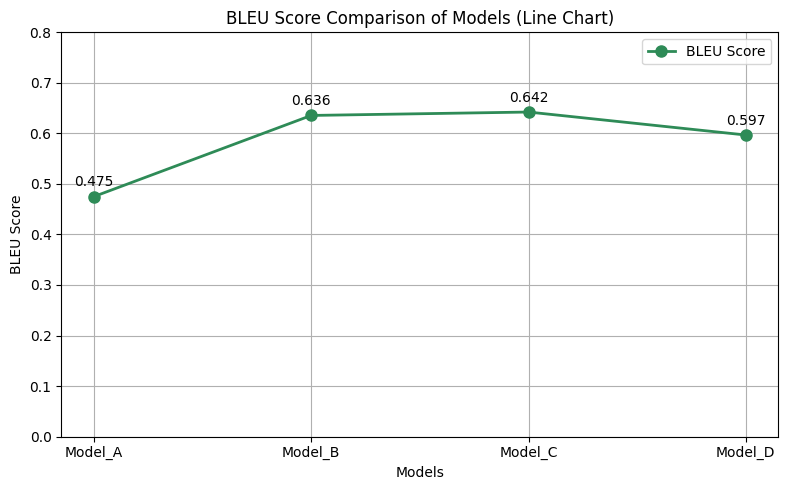

In [2]:
import json
import matplotlib.pyplot as plt

# Load the BLEU scores from the JSON file
file_path = "bleu_scores.json"
with open(file_path, "r") as file:
    bleu_data = json.load(file)

# Extract model names and BLEU scores
models = list(bleu_data.keys())
bleu_values = [bleu_data[model]["bleu"] for model in models]
# Create a line chart for BLEU scores
plt.figure(figsize=(8, 5))
plt.plot(models, bleu_values, marker='o', linestyle='-', linewidth=2, markersize=8, label="BLEU Score", color='seagreen')

for i, txt in enumerate(bleu_values):
    plt.text(models[i], txt + 0.02, f"{txt:.3f}", ha='center', fontsize=10)


plt.xlabel("Models")
plt.ylabel("BLEU Score")
plt.title("BLEU Score Comparison of Models (Line Chart)")
plt.ylim(0, 0.8)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


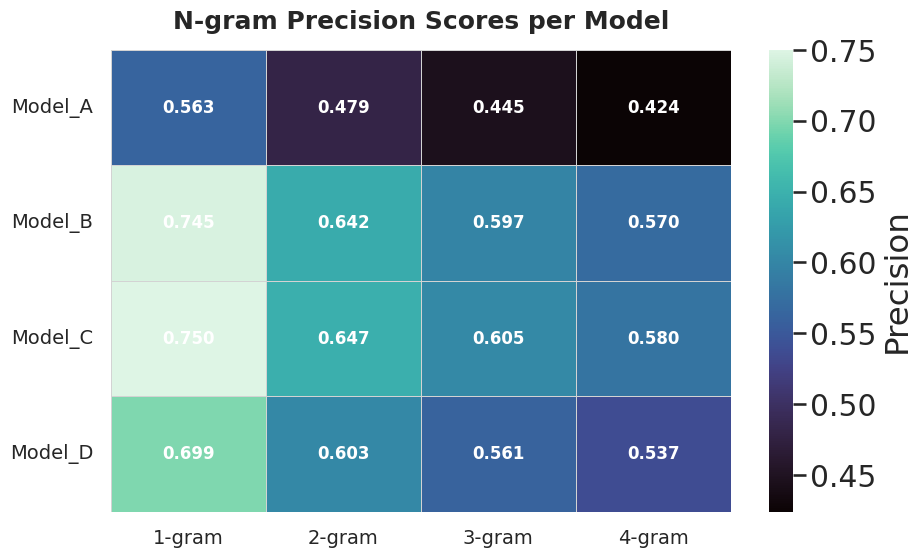

In [4]:
# Organizing data into a DataFrame
import pandas as pd
import seaborn as sns

# Extract precision values
models = list(bleu_data.keys())
n_grams = ['1-gram', '2-gram', '3-gram', '4-gram']
df_prec = pd.DataFrame([bleu_data[m]['precisions'] for m in models], index=models, columns=n_grams)

# Set style for an elegant scientific look
sns.set(style="white", context="talk", font_scale=1.3)

# Create the figure
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(
    df_prec, annot=True, fmt=".3f", cmap="mako",
    linewidths=0.5, linecolor='lightgray', cbar_kws={'label': 'Precision'},
    annot_kws={"size": 12, "weight": "bold", "color": "white"}
)

# Improve readability
plt.xticks(rotation=0, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.title("N-gram Precision Scores per Model", fontsize=18, weight="bold", pad=15)

# Show the heatmap
plt.show()